# Short-coding Project 3: Tumour segmentation

## How it works ?
Despite the long code defining the functions, the principle used is quite simple. The big picture is to use the watershed transform to isolate regions, then merge the ones with similar mean pixel values, to finally obtain two 'super-regions': the tumor, and the rest. Because the brain tumour on the MRI provided is quite hihgly contrasted with the rest of the brain and the background, the hope is that we can use a big 'mean-pixel-value difference' for the merge part, and thus end up with as few regions as possible (2 at the best). Of course, this is the point where the automation of the algorithm has its weakness: is it really automatic as we still have to hard-code this value ? There are arguments for and against this question, but the one that I will give here is that we will in all cases have to enter some values in the code (such as when searching for the peak local minima in the gradient image), and that this value would remain the same if we wanted to analyze another MRI of the same type. 

## The functions
We first need to set the markers for the watershed transform. This is simply done with the skimage functions 'label' and 'peak_local_max' used on the gradient (inversed, actually, and filtered out with a median filter) image of our MRI. All of this is combined in the function `im2markers`, taking the initial image as the only parameter (as discussed above, the minimum intensity of peaks or the minimum distance separating two peaks are hard-coded).

Then, we apply the watershed transform with the `im2regions` function, that takes into parameter the initial image, as well as the newly defined markers. (Note that we calculate the gradient image again, this is only for readability and simplicity purposes, of course im2markers could also return it to avoid to calculate it twice.) We also return the number of regions, which we will use later.

After that, the merging phase begins. `mergeRegions` is the main function of this part, that determines the regions to be merged together. Again, as discussed, the value 80 is hard-coded and chosen by hand. Some comments in the code explain the choices made as well as the limitation of the function (note that there might be easier ways to do what the function does, but this code implements it in a simple way). The function then calls `mergeLabels`, which actually merge the regions, as well as `renameLabels` that just renames them to be consistent (after the merge we might have the labels 1 and 4, and it just renames them to 0 and 1). We assume here that the tumour region will have a label higher than 1, and the rest will have 1. This assumption is justified by two things. First, the function mergeLabels will give as new label to the merge region the smallest one that appeared in the list. Second, the label function from skimage will give the labels in increasing order, beginning by the top left corner of the image. Thus, we can make our assumption hoping that the tumour is not contained in the top-left region (which must be the background, as few people have a rectangle head, again assuming that the whole head contour is visible in the MRI). We then chose to give the label 0 to the rest and 1 to the tumour.

Finally, given the newly found 'super-regions', `calculateArea` estimates the area of the tumour based on the centimeter-to-pixel ratio that was given. Because of our labelling choice, the number of pixels corresponding to the tumour is simply the sum of all the pixel values in the image.


In [230]:
import skimage.filters.rank as skr
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread,imshow
from skimage.morphology import watershed,disk
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2gray
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage import img_as_ubyte
%matplotlib inline

def im2markers(im):
    gradient = skr.gradient(skr.median(im,disk(3)), disk(3))
    gradientinv = gradient.max()-gradient
    markers = label(peak_local_max(gradientinv, indices=False, threshold_rel=0.995, min_distance=20))
    return markers

def im2regions(im, markers):
    gradient = skr.gradient(skr.median(im,disk(3)), disk(3))
    regions = watershed(gradient, markers)
    nregions = np.max(markers) # Determine the number of regions
    return regions, nregions 

def mergeLabels(image, labels_to_merge):
    labels_map = np.arange(np.max(image) + 1)
    labels_map[labels_to_merge] = np.min(labels_to_merge)
    return labels_map[labels_image]

def renameLabels(mergedregions):
    newimage = (mergedregions > 1).astype(int) 
    return newimage

def mergeRegions(regions, nregions):
    # Determining pixel value for each region
    meanpix_per_region = np.zeros(nregions) 
    for i in range(nregions):
        regionmask = regions == i+1
        oneregion = regionmask*im
        meanpix_per_region[i] = np.mean(oneregion[oneregion>0]) 

    # Merging regions which mean values are less than 80 in difference
    # We want to have a list of lists of all regions to merge at the end 
    # Example: if we want to merge (2 and 3), and (6, 7 and 8), we want to have [[2, 3], [6, 7, 8]]
    regstomerge = []
    regstomerge_tot = []
    for i in range(nregions-1):
        regstomerge_old = regstomerge
        regstomerge = []
        for j in range(i+1,nregions):
            if i == j:
                continue
            if abs(meanpix_per_region[i]-meanpix_per_region[j]) < 80:
                regstomerge.append(i+1) if i+1 not in regstomerge else regstomerge
                regstomerge.append(j+1) 
        for val in regstomerge:
            if val in regstomerge_old:
                toappend = list(set(regstomerge+regstomerge_old)) # list(set()) : to remove duplicates
                regstomerge_tot.append(toappend)
                break


    if len(regstomerge_tot)>0:
        for i in range(len(regstomerge_tot)-1):
            for val in regstomerge_tot[i]:
                # If there is a common value in 2 lists, combine them in the first and delete the second
                # Note that we consider only consecutive lists, as we assume that the number of 'super-regions' 
                # (regions after merging) is quite small (we want maximum 2)
                if val in regstomerge_tot[i+1]:
                    regstomerge_tot[i] = list(set(regstomerge_tot[i]+regstomerge_tot[i+1]))
                    regstomerge_tot.pop(i+1)
                    break

    # Finally merge the regions 
    for labels_list in regstomerge_tot:
        newregions = mergeLabels(regions, labels_list)
    
    newregions = renameLabels(newregions)
    return newregions

def calculateArea(regionsbin, ratio):
    npix = np.sum(regionsbin)
    area = ratio * npix
    return area

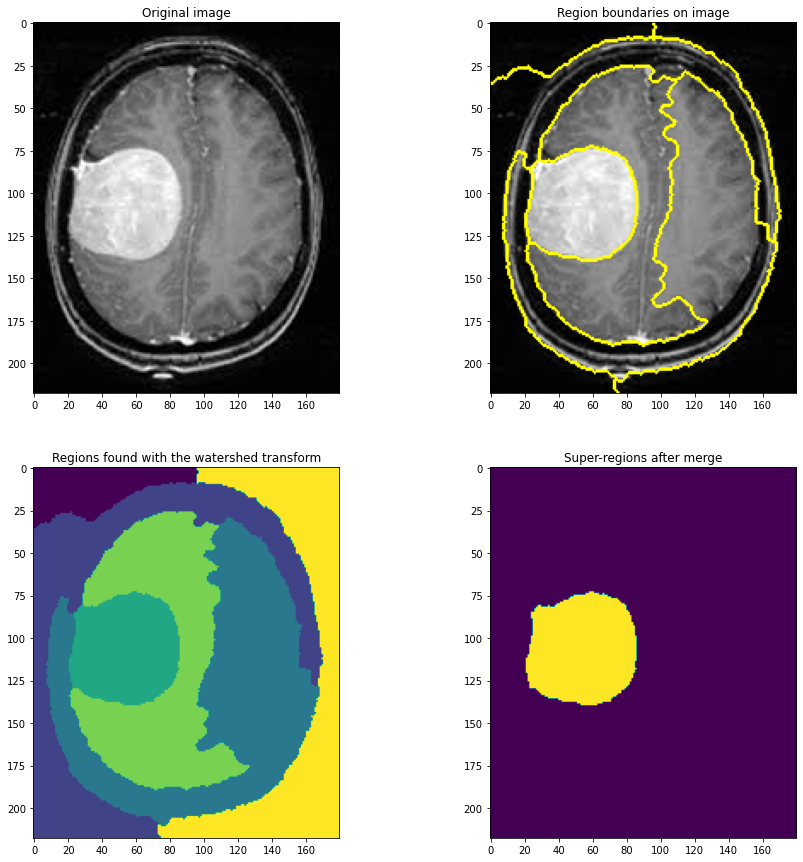

Estimated area of the tumor: 46.6049 cm²


In [231]:
# ORIGINAL IMAGE
im = img_as_ubyte(rgb2gray(imread('mri_brain.jpg')))

# CM-TO-PIX RATIO
ratio = 0.115**2

# Finding markers
markers = im2markers(im)

# Creating regions
regions, nregions = im2regions(im, markers)

# Merging them into super-regions
newregions = mergeRegions(regions, nregions)

# Estimating tumour area
area = calculateArea(newregions, ratio)

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(im, cmap='gray')
plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(mark_boundaries(im,regions))
plt.title('Region boundaries on image')
plt.subplot(2,2,3)
plt.imshow(regions)
plt.title('Regions found with the watershed transform')
plt.subplot(2,2,4)
plt.imshow(newregions)
plt.title('Super-regions after merge')
plt.show()
print('Estimated area of the tumor: {} cm\u00b2'.format(area))